In [1]:
from google.colab import drive 
drive.mount('/content/drive')

# Tensorflow 2.x is used 
%tensorflow_version 2.x

#IMPORTS
import os
from google.colab import files
import matplotlib.pyplot as plt
import math
import numpy as np
from PIL import Image
import cv2 as cv
from random import shuffle
from skimage.color import rgb2gray

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten, Conv2D,MaxPooling2D
import keras.backend as K

# Training is done on a GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

Mounted at /content/drive


In [23]:
def process_data(data_dir):
  data_dict = {}
  file_name_array = []
  for file in os.scandir(file_name):
    #print(file.path)
    file_loc = file.path.split('Bismuth_Data_Processed')[1]
    if file_loc.endswith(".jpg"):      
      if 'off' in file_loc.lower() or 'on' in file_loc.lower():
        photo = Image.open(file.path)
        file_loc_cropped = file_loc.lower().strip().replace(' ','')
        #print(file_loc_cropped)
        #bw_photo_arr = rgb2gray(np.array(photo))
        photo_arr = np.array(photo)
        file_name_array.append(file_loc_cropped)
        data_dict[file_loc_cropped]=photo_arr
        #print(len(data_array))
  print("Done! Added {} images".format(len(data_dict.values())))
  return file_name_array, data_dict


In [ ]:
data_dir = '/content/drive/MyDrive/Bismuth_Data_Processed/'
date = "2021-02-" + input("Which day's scan do you want to analyze?") + "/scans/scan"
print("Date: " + date)
scan_num = input("Which scan do you want to analyze?")
dir_name = data_dir + date + scan_num + "/"
print("Directory name: "+dir_name)
#for file in os.scandir(file_name):
#  print(file.path)
file_name_array, data_dict = process_data(dir_name)
file_name_array.sort()
#print(file_name_array)

In [39]:
data_arr = []
for file_name in file_name_array:
  data_arr.append([data_dict[file_name],file_name])
print("This scan has: {} files".format(len(data_arr)))

This scan has: 22 files


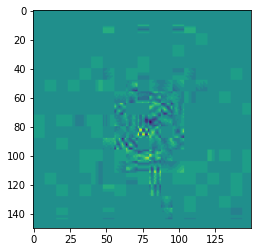

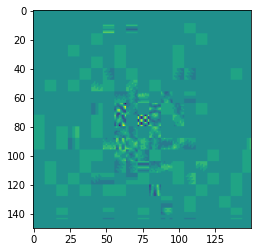

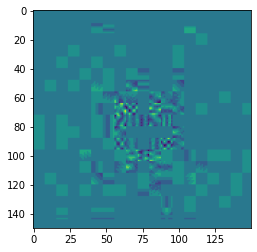

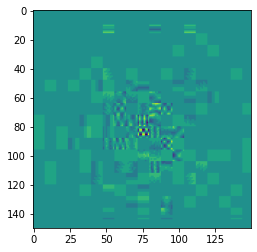

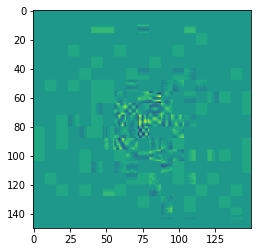

Done! Have 11 usable images


In [55]:
#Commented bc I've already saved array to npy file
subtracted_photos = []
subtracted_photos_gray = []
for index in range(0,len(data_arr)-1):

  off_file_name = data_arr[index][1]
  off_file_name_split = off_file_name.split('scan',3)[3]
  off_file_num = int(off_file_name_split.split("_",2)[0])*1000+int(off_file_name.split("_",2)[1])
  off_photo = data_arr[index][0]

  on_file_name = file_name_array[index+1]
  on_file_name_split = on_file_name.split('scan',3)[3]
  on_file_num = int(on_file_name_split.split("_",2)[0])*1000+int(on_file_name.split("_",2)[1])
  on_photo = data_arr[index+1][0]
  
  if (on_file_num == off_file_num + 1) and ('on' in on_file_name) and ('off' in off_file_name):    
    off_photo_gray = np.array(rgb2gray(off_photo))
    on_photo_gray = np.array(rgb2gray(on_photo))
    sub_photo = (on_photo-off_photo)/255
    sub_photo_gray = (on_photo_gray-off_photo_gray)/255   

    if not np.array_equal(sub_photo,np.zeros((150,150,3))):
      subtracted_photos.append(np.concatenate((np.zeros((17, 150,3)),sub_photo[17:133,:,:],(np.zeros((17, 150,3)))),axis=0))
      subtracted_photos_gray.append(np.concatenate((np.zeros((17, 150)),sub_photo_gray[17:133,:],(np.zeros((17, 150)))),axis=0))

    if index < 10:
      plt.imshow(sub_photo_gray)
      plt.show()

print("Done! Have {} usable images".format(len(subtracted_photos)))

In [67]:
#subtracted_photos = np.array(np.load('/content/drive/MyDrive/Bismuth_Data_Processed/Subtracted_Images_RGB.npy',allow_pickle=True))
#np.random.shuffle(subtracted_photos)
"""
for i in range(0,len(subtracted_photos)):
  subtracted_photos[i][0]= np.concatenate((np.zeros((17, 150,3)),subtracted_photos[i][0][17:133,:,:],(np.zeros((17, 150,3)))),axis=0)#np.concatenate(np.zeros((17, 150,3)),subtracted_photos[i][0][17:133,:,:],np.zeros((17, 150,3)))
print(len(subtracted_photos))
plt.imshow(subtracted_photos[0][0])
plt.show()
"""

(1884, 2)


'\nfor i in range(0,len(subtracted_photos)):\n  subtracted_photos[i][0]= np.concatenate((np.zeros((17, 150,3)),subtracted_photos[i][0][17:133,:,:],(np.zeros((17, 150,3)))),axis=0)#np.concatenate(np.zeros((17, 150,3)),subtracted_photos[i][0][17:133,:,:],np.zeros((17, 150,3)))\nprint(len(subtracted_photos))\nplt.imshow(subtracted_photos[0][0])\nplt.show()\n'

In [70]:
# Defines the neural network that will be trained on the player's data 
# Returns uncompiled network
def build_resnet_model(lr): #reaches 72% accuracy on on/off classification
  """
  Transfer learning: a ResNet50 trained on imagenet is used with its last 4 layers removed.
  Trainable fully connected layers are added on top of the imagenet conv layers
  Dropout was initially used but was later removed for performance reasons
  https://towardsdatascience.com/pitfalls-with-dropout-and-batchnorm-in-regression-problems-39e02ce08e4d
  """
  resnet = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

  for layer in resnet.layers[:-4]:
    layer.trainable = False

  # Prints network details for debugging
  """
  for layer in resnet.layers:
    print(layer, layer.trainable)
  """

  model = Sequential()
  model.add(resnet)
  # model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(500, activation='tanh'))
  # model.add(Dropout(0.5))
  model.add(Dense(200, activation='tanh'))
  # model.add(Dropout(0.5))
  model.add(Dense(50, activation='tanh'))
  # model.add(Dropout(0.5))
  model.add(Dense(10, activation='tanh'))
  # model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))
  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate = lr), metrics=['accuracy'])
  return model

def build_cnn_model(): #reaches 75% accuracy on on/off classification
  cnn_model = keras.Sequential([
      keras.layers.Conv2D(filters=36,input_shape=(150,150,3),kernel_size=(5,5),activation=tf.nn.relu),           
      keras.layers.MaxPool2D(pool_size=(2, 2)),
      keras.layers.Conv2D(filters=72,kernel_size=(5,5),activation=tf.nn.relu), 
      keras.layers.MaxPool2D(pool_size=(2, 2)),
      keras.layers.Conv2D(filters=144,kernel_size=(5,5),activation=tf.nn.relu), 
      keras.layers.MaxPool2D(pool_size=(2, 2)),
      keras.layers.Flatten(),
      keras.layers.Dense(250, activation=tf.nn.relu),
      #keras.layers.Dropout(0.6),
      keras.layers.Dense(1)#, activation=tf.nn.softmax)
  ])
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=2e-3,
      decay_steps=10000,
      decay_rate=0.95)
  optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
  cnn_model.compile(loss='mse', optimizer=optimizer, metrics=[linear_regression_equality])
  #cnn_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate = 0.001), metrics=['accuracy'])
  return cnn_model



----- --------STARTING EPOCH 0-------------
229/229 [==============================] - 5s 21ms/step - loss: 0.8538 - accuracy: 0.5673 - val_loss: 0.5849 - val_accuracy: 0.6168
----- --------STARTING EPOCH 1-------------
229/229 [==============================] - 5s 20ms/step - loss: 0.5644 - accuracy: 0.6459 - val_loss: 0.5615 - val_accuracy: 0.6102
----- --------STARTING EPOCH 2-------------
229/229 [==============================] - 5s 20ms/step - loss: 0.5256 - accuracy: 0.6778 - val_loss: 0.6175 - val_accuracy: 0.6496
----- --------STARTING EPOCH 3-------------
229/229 [==============================] - 5s 20ms/step - loss: 0.4798 - accuracy: 0.6960 - val_loss: 0.5002 - val_accuracy: 0.6969
----- --------STARTING EPOCH 4-------------
229/229 [==============================] - 5s 20ms/step - loss: 0.4517 - accuracy: 0.7103 - val_loss: 0.5993 - val_accuracy: 0.7021
----- --------STARTING EPOCH 5-------------
229/229 [==============================] - 5s 22ms/step - loss: 0.4391 - acc

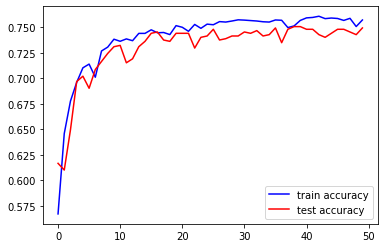

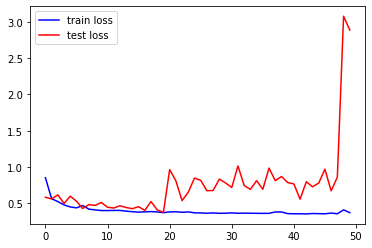

In [55]:

#model = build_resnet_model(0.0008)
model = build_cnn_model()
accuracy_values = []
validation_accuracy_values= []
loss_values = []
validation_loss_values = []

EPOCHS = 50

#Training Neural Net
for i in range(0,EPOCHS):
  print('----- --------STARTING EPOCH {}-------------'.format(i))

  history = model.fit(photos_array,labels_array,batch_size=30,epochs=1,validation_split=0.1)

  #Storing accuracy and loss values
  accuracy_values.append(history.history['accuracy'][0])
  validation_accuracy_values.append(history.history['val_accuracy'][0])
  loss_values.append(history.history['loss'][0])
  validation_loss_values.append(history.history['val_loss'][0])

#Plotting NN performance
f1 = plt.figure()
f2 = plt.figure()
ax1 = f1.add_subplot(111)

ax1.plot(accuracy_values, "-b",label = "train accuracy")
ax1.plot(validation_accuracy_values, "-r",label = "test accuracy")
ax1.legend()
ax2 = f2.add_subplot(111)
ax2.plot(loss_values, "-b",label = "train loss")
ax2.plot(validation_loss_values, "-r",label = "test loss")
ax2.legend()
plt.show()
